# 最終課題：犬と猫の分類

## 仕様
最終課題用のノートブックのなかに、犬と猫の画像を学習したモデルを作成して、分類を行なうプログラムを作成してください。

- 本レッスン内容で学習した流れに沿って、深層学習プログラムを作成してください
- データの前処理や水増しの処理を入れてください
- MobileNetV2 のモデルを利用してください（画像サイズは MobileNetV2 が対応する大きさへのリサイズが必要です）
- 必ず最後に evaluate() を実行して、正答率がわかるようにしてください。

### 訓練データとテストデータそれぞれの画像ファイルを読み込む

In [1]:
# 訓練データとテストデータの画像を読み込む
# （サイズは縦横224pxにリサイズする）
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/train",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dog_cat_photos/test",
    image_size=(224, 224),
    label_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


#### データを確認する

In [2]:
# データの詳細を表示する
list(train_dataset.as_numpy_iterator())[0]

2025-08-14 15:50:14.474973: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[[210.       , 208.       , 222.       ],
          [210.00447  , 208.00893  , 221.99553  ],
          [210.6741   , 209.34822  , 221.3259   ],
          ...,
          [231.95538  , 228.64064  , 233.29243  ],
          [235.97327  , 230.9844   , 236.9755   ],
          [236.       , 231.       , 237.       ]],
 
         [[210.       , 208.00223  , 221.8683   ],
          [210.00447  , 208.01118  , 221.8639   ],
          [210.6741   , 209.35347  , 221.20624  ],
          ...,
          [231.727    , 228.42564  , 233.04915  ],
          [235.74115  , 230.76569  , 236.72998  ],
          [235.76785  , 230.78125  , 236.75447  ]],
 
         [[210.       , 208.33705  , 202.11383  ],
          [210.00447  , 208.34898  , 202.12141  ],
          [210.6741   , 210.1397   , 203.25742  ],
          ...,
          [197.46983  , 196.17741  , 196.55736  ],
          [200.92345  , 197.95691  , 199.90186  ],
          [200.94643  , 197.96875  , 199.9241   ]],
 
         ...,
 
         [[1

In [3]:
# 分類名（no／yes）をリストとして格納する
class_names = train_dataset.class_names
class_names

['cat', 'dog']

2025-08-14 15:50:14.537717: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


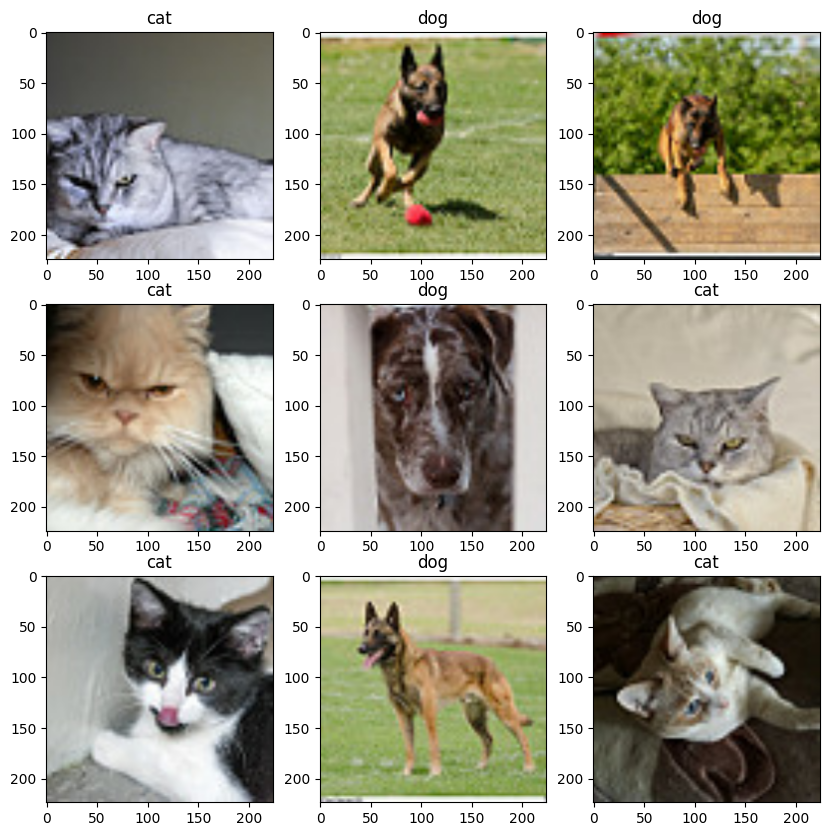

In [4]:
# 訓練データの一部を表示して確認
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### データの水増しを行なう

In [5]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label):   # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label):      # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label):             # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

def rot180(image, label):            # 反時計回りに180度回転
    image = tf.image.rot90(image, k=2)
    return image, label

def rot270(image, label):            # 反時計回りに270度回転
    image = tf.image.rot90(image, k=3)
    return image, label

In [6]:
# 画像の水増し処理の実行
train_dataset_lr     = train_dataset.map(flip_left_right)
train_dataset_ud     = train_dataset.map(flip_up_down)
train_dataset_rot90  = train_dataset.map(rot90)
train_dataset_rot180 = train_dataset.map(rot180)
train_dataset_rot270 = train_dataset.map(rot270)

In [7]:
# 水増ししたデータを訓練データに追加する
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)
train_dataset = train_dataset.concatenate(train_dataset_rot180)
train_dataset = train_dataset.concatenate(train_dataset_rot270)

In [8]:
# データをシャッフルする
train_dataset = train_dataset.shuffle(32)

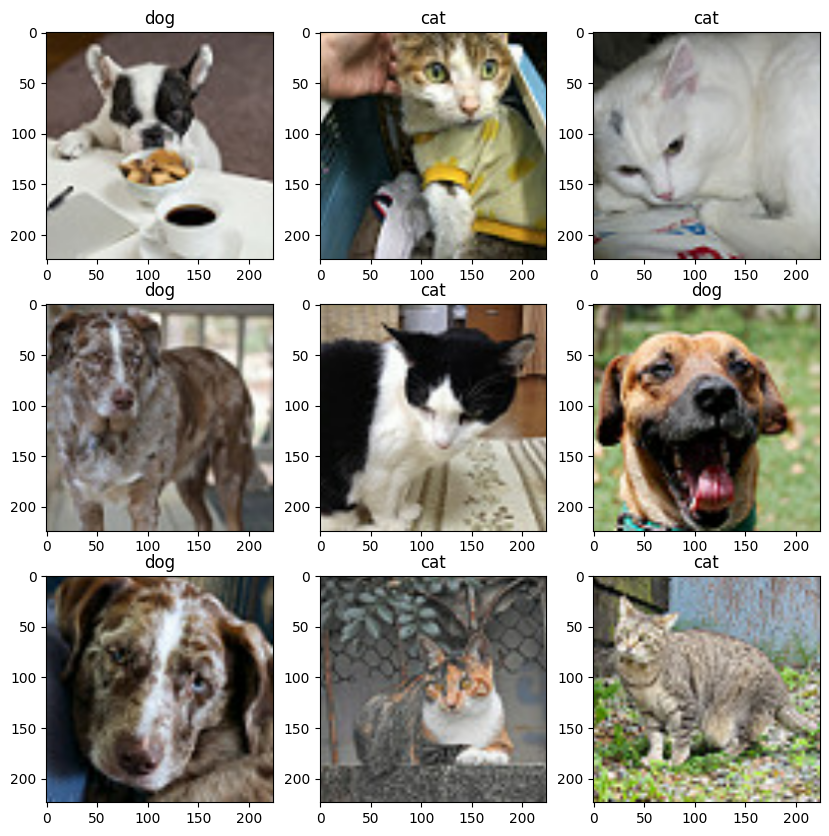

In [9]:
# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])

### モデルを作って学習する

#### MobileNetV2の学習済みモデルを読み込む

In [10]:
# MobileNetV2モデルを作成する
input_layer = tf.keras.Input(shape=(224, 224, 3))   # 入力層
l_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)   # 前処理（正規化）をする層

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    input_tensor=l_layer,
    include_top=False,
    weights="imagenet",
    pooling='avg'
)
base_model.trainable = False

#### 出力層を作成する

In [11]:
# Dense層を追加する
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#### モデルを完成させる

In [12]:
# base_modelに先ほどのDense層を追加したモデルを作成する
model = tf.keras.Sequential([
    base_model,
    output_layer
])

In [13]:
# modelをcompileする
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [14]:
# modelに学習させる
model.fit(train_dataset, epochs=20)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.7917 - loss: 0.4328
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9261 - loss: 0.2204
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9461 - loss: 0.1714
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9617 - loss: 0.1372
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9672 - loss: 0.1163
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9733 - loss: 0.1019
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9789 - loss: 0.0897
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9822 - loss: 0.0787
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9861 - loss: 0.0709
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.9878 - loss: 0.0637
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.9900 - loss: 0.0584
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - 

In [15]:
# テストデータで分類を実行する
pred_data = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


In [16]:
# 分類した結果を確認する
pred_data

array([[5.7137338e-05],
       [4.0562890e-04],
       [3.4775279e-05],
       [1.6392107e-03],
       [7.0752582e-04],
       [2.2132731e-04],
       [6.4649055e-04],
       [1.0264838e-03],
       [1.3784095e-05],
       [2.5520977e-04],
       [7.1952141e-05],
       [2.1168145e-03],
       [3.9067212e-03],
       [7.0493226e-04],
       [3.4434684e-05],
       [3.5763701e-06],
       [1.2274089e-04],
       [5.3302723e-04],
       [5.9401230e-03],
       [1.9083066e-03],
       [5.1035807e-03],
       [5.8950264e-02],
       [2.4318891e-03],
       [3.9640741e-04],
       [1.5051965e-01],
       [1.7034304e-03],
       [9.2743977e-04],
       [2.7949267e-04],
       [8.2552833e-03],
       [1.8091555e-04],
       [5.7186052e-04],
       [6.4488751e-01],
       [7.8022014e-04],
       [2.0510524e-03],
       [3.2181598e-03],
       [8.7617821e-01],
       [8.5513797e-03],
       [1.1036462e-03],
       [1.6438527e-02],
       [4.0094694e-04],
       [2.8173198e-04],
       [5.511925

In [17]:
# evaluate()でモデルの性能を評価する
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9600 - loss: 0.0653 


[0.06531626731157303, 0.9599999785423279]